In [30]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

In [31]:
images_train_directory = '../images/ic/train'
images_val_directory = '../images/ic/validation'
images_test_directory = '../images/ic/test'

batch_size = 32
img_size = (256, 256)

### Getting data:

In [32]:
class_names = ['incorrect', 'correct']

train_ds = tf.keras.utils.image_dataset_from_directory(
  images_train_directory,
  class_names=class_names,
  seed=123,
  image_size=img_size,
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  images_val_directory,
  class_names=class_names,
  shuffle=False,
  image_size=img_size,
  batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  images_test_directory,
  class_names=class_names,
  shuffle=False,
  image_size=img_size,
  batch_size=batch_size
)     

Found 4001 files belonging to 2 classes.
Found 868 files belonging to 2 classes.
Found 941 files belonging to 2 classes.


### Creating the CNN:

In [33]:
ic_model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(256, 256, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3042, activation='relu'),# activity_regularizer=tf.keras.regularizers.l2(REGULARIZATION_LAMBDA)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2028, activation='relu'),# activity_regularizer=tf.keras.regularizers.l2(REGULARIZATION_LAMBDA)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1014, activation='relu'),# activity_regularizer=tf.keras.regularizers.l2(REGULARIZATION_LAMBDA)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),# activity_regularizer=tf.keras.regularizers.l2(REGULARIZATION_LAMBDA)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),# activity_regularizer=tf.keras.regularizers.l2(REGULARIZATION_LAMBDA)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),# activity_regularizer=tf.keras.regularizers.l2(REGULARIZATION_LAMBDA)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),# activity_regularizer=tf.keras.regularizers.l2(REGULARIZATION_LAMBDA)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate=0.001,
  decay_steps=10000,
  decay_rate=0.9
  )

ic_model.compile(
  loss='binary_crossentropy',
  optimizer=tf.optimizers.SGD(learning_rate=lr_schedule),
  metrics=['accuracy'],
)

ic_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)       

Evaluate the model without any loaded weights:

In [34]:
ic_model.evaluate(val_ds)

2022-11-19 16:17:56.807474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 2s 62ms/step - loss: 0.6919 - accuracy: 0.6290


[0.691888689994812, 0.6290322542190552]

### Load trained model and evaluate:

In [35]:
ic_model.load_weights('./models/ic_model_w_v4.h5')

In [36]:
ic_model.evaluate(val_ds)

28/28 [==============================] - 2s 63ms/step - loss: 0.1269 - accuracy: 0.9516


[0.12691301107406616, 0.9516128897666931]

As expected, the accuracy in this case ($95$%) is better than without training ($33$%). Let's check the confusion matrix:

In [37]:
# predicitons and true values over the validation set
ic_validations_labels = np.array(list(map(lambda x: x[1], val_ds.unbatch().as_numpy_iterator())))
ic_predictions = ic_model.predict(val_ds).reshape(-1)

 3/28 [==>...........................] - ETA: 1s

2022-11-19 16:18:02.491545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 2s 58ms/step


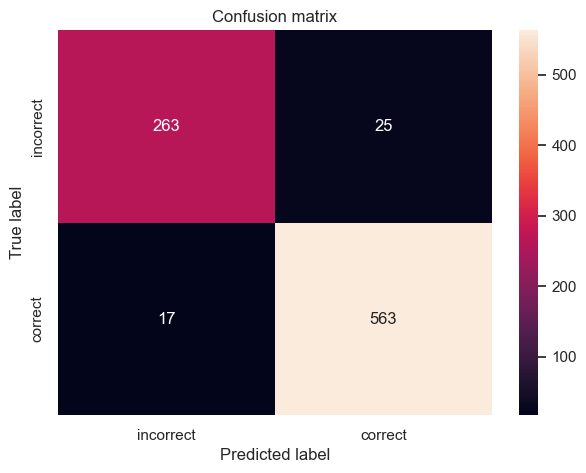

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# confusion matrix
ic_cm_old = confusion_matrix(ic_validations_labels, ic_predictions > 0.5)

sns.heatmap(ic_cm_old, annot=True, fmt="d", ax=ax)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
ax.set_xticklabels(val_ds.class_names)
ax.set_yticklabels(val_ds.class_names)
ax.set_title("Confusion matrix")

plt.show()

The *Precision* of this model is about $95.5$% and the *Recall* is $96.9$% with a *Threshold* of $0.5$%. There are $25$ wrong predictions of a **correct** picture and $563$ good predictions.

In [39]:
# get more granularity in the predictions
ic_preds_1 = ic_predictions > 0.5
ic_prediction_1 = ic_predictions[ic_preds_1]  # get the probs predictions from model
ic_pred_label = np.where(ic_prediction_1 > 0.5, 1, 0)  # get the labels from probs
ic_true_1 = ic_validations_labels[ic_preds_1]  # get the true values for predictions
ic_errors_1 = np.where(ic_pred_label != ic_true_1, True, False) # get the errors
ic_errors_1_images = np.array(val_ds.file_paths)[ic_preds_1][ic_errors_1]  # get the images that are errors

(25, 1)
(563, 1)


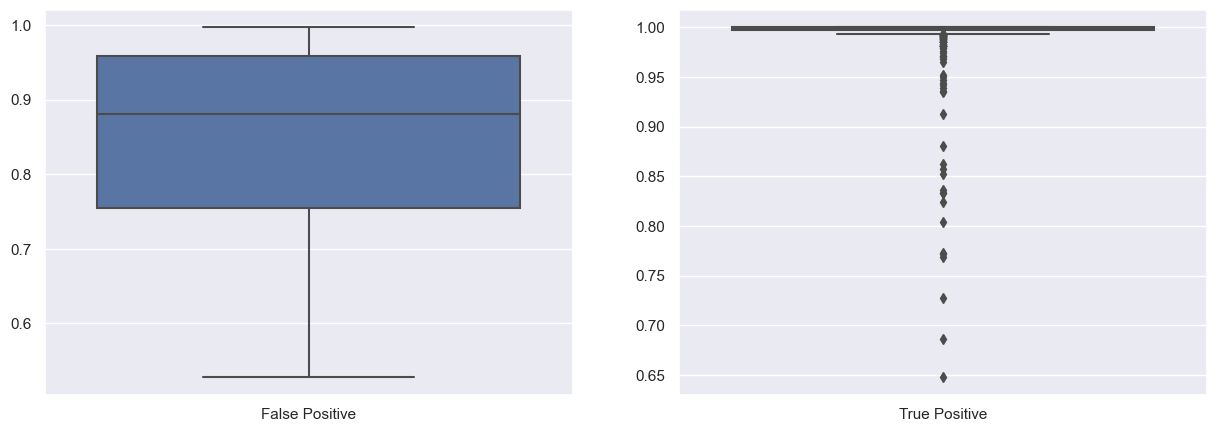

In [40]:
error_df = pd.DataFrame(ic_prediction_1[ic_errors_1], columns=['False Positive'])
correct_df = pd.DataFrame(ic_prediction_1[~ic_errors_1], columns=['True Positive'])
print(error_df.shape)
print(correct_df.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(data=error_df, orient='v', ax=ax[0])
sns.boxplot(data=correct_df, orient='v', ax=ax[1])
plt.show()

The distribution of the predictions in case of *False Positive* is more simetrical regarding to *True Positive*'s distribution, which has a skew to $1$. Let's check those images where the algorithm predicted a **correct** picture but it was an **incorrect** one. The predicted value is the probability of a **correct** picture.

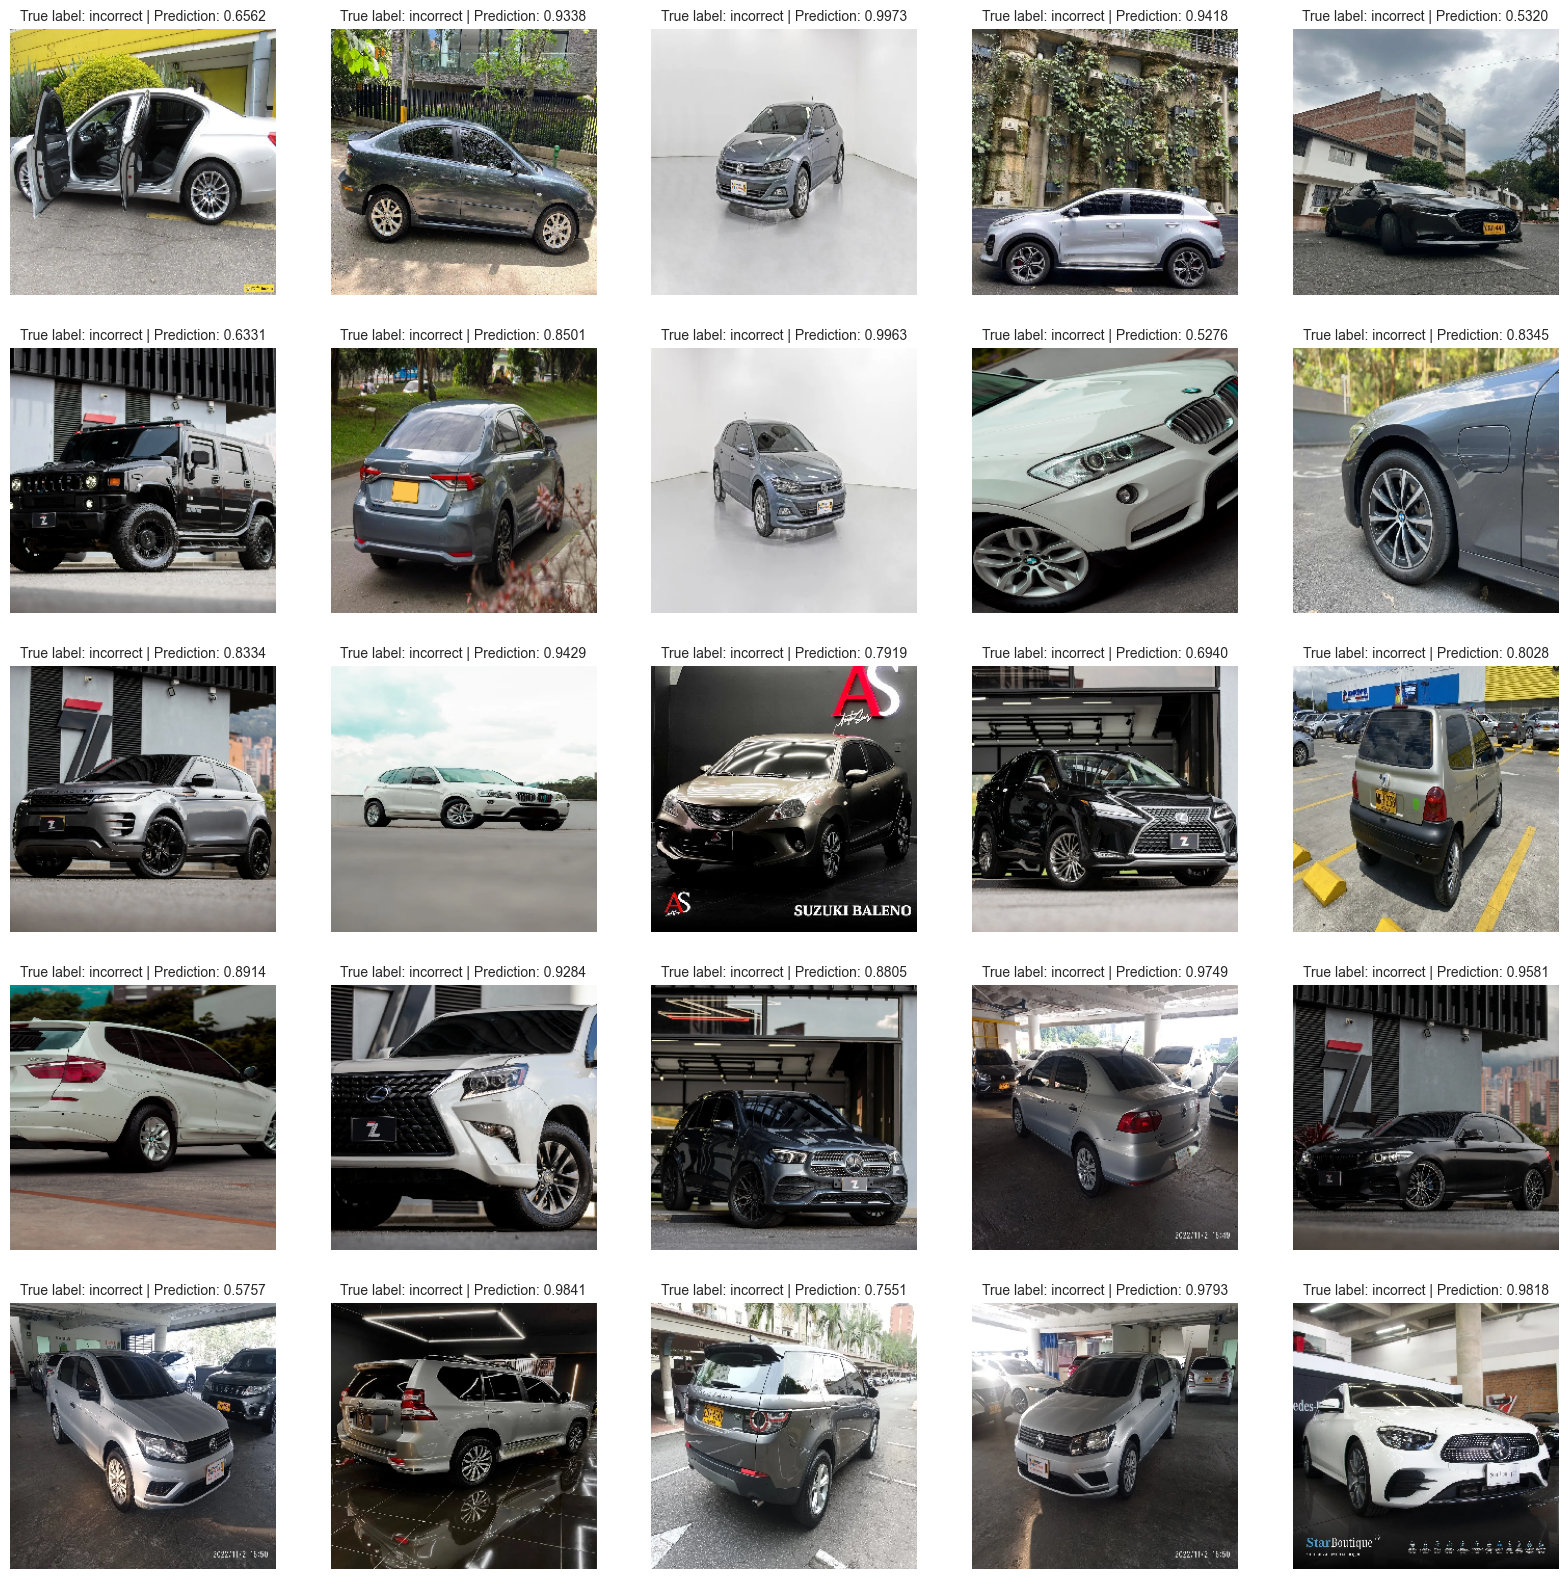

In [41]:
fig, ax = plt.subplots(5, 5, figsize=(20, 20))

for i, ax in enumerate(fig.axes):
  try:
    error_image = tf.keras.preprocessing.image.load_img(ic_errors_1_images[i])
    ax.imshow(error_image)
    ax.axis('off')
    ax.set_title(f'True label: {val_ds.class_names[ic_true_1[ic_errors_1][i]]} | Prediction: {ic_prediction_1[ic_errors_1][i]:.4f}', fontsize=10)
  except IndexError:
    continue
plt.show()

One of the main questions is which *threshold* to use in order to have a good *precision* or a good *recall* (there is a trade-off):

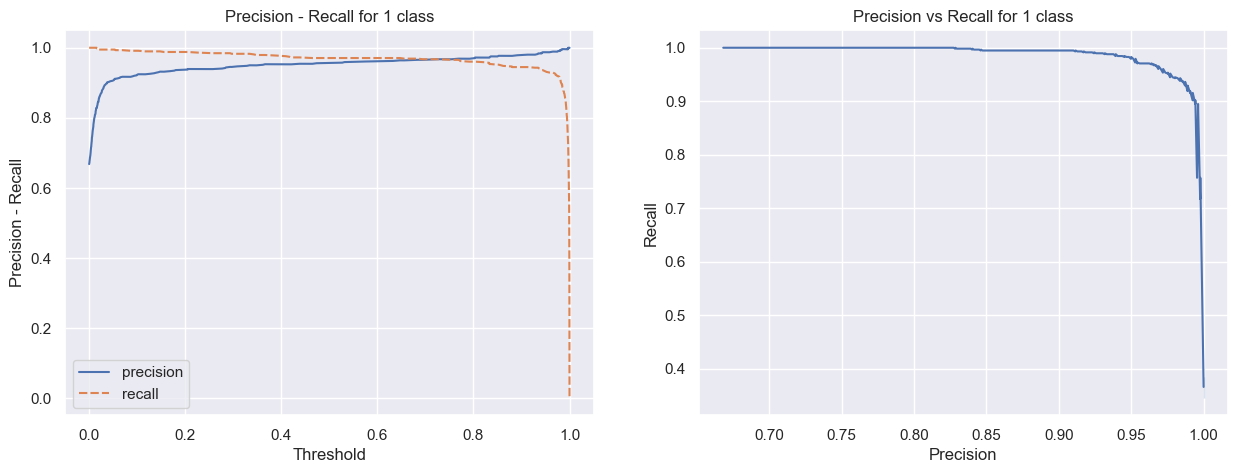

In [42]:
precision, recall, thresholds = precision_recall_curve(ic_validations_labels, ic_predictions)
prt = pd.DataFrame({'precision': precision[:-1], 'recall': recall[:-1]}, index=thresholds)
# prt = prt[(prt.index <= 0.999)]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(data=prt, ax=ax[0])
ax[0].set_ylabel('Precision - Recall')
ax[0].set_xlabel('Threshold')
ax[0].set_title(f'Precision - Recall for 1 class')

sns.lineplot(x='precision', y='recall', data=prt, ax=ax[1])
ax[1].set_ylabel('Recall')
ax[1].set_xlabel('Precision')
ax[1].set_title(f'Precision vs Recall for 1 class')
plt.show()

Example of a confusion matrix with a *threshold* of $0.95$:

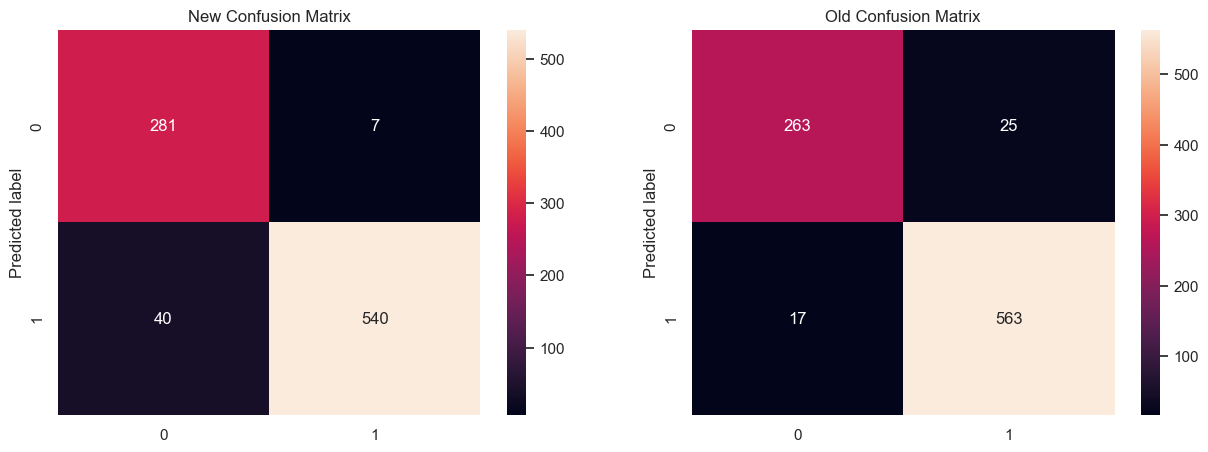

In [43]:
new_label_predictions = np.zeros(ic_predictions.shape)
thresholld = 0.95
for idx, row in enumerate(ic_predictions):
  new_label_predictions[idx] = 1 if row > thresholld else 0

ic_new_cm = confusion_matrix(ic_validations_labels, new_label_predictions)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.heatmap(ic_new_cm, annot=True, fmt="d", ax=ax[0])
ax[0].set_title('New Confusion Matrix')
ax[0].set_ylabel('Actual label')
ax[0].set_ylabel('Predicted label')

sns.heatmap(ic_cm_old, annot=True, fmt="d", ax=ax[1])
ax[1].set_title('Old Confusion Matrix')
ax[1].set_ylabel('Actual label')
ax[1].set_ylabel('Predicted label')

plt.show()

### Evaluate the model on Test Set:

In [44]:
ic_model.evaluate(test_ds)

30/30 [==============================] - 3s 69ms/step - loss: 0.1714 - accuracy: 0.9511


[0.1713808923959732, 0.9511158466339111]

Overall, the model has an **accuracy** of $95$% in the test set.

In [45]:
ic_test_predictions = ic_model.predict(test_ds)
ic_test_labels = np.array(list(map(lambda x: x[1], test_ds.unbatch().as_numpy_iterator())))

30/30 [==============================] - 2s 61ms/step


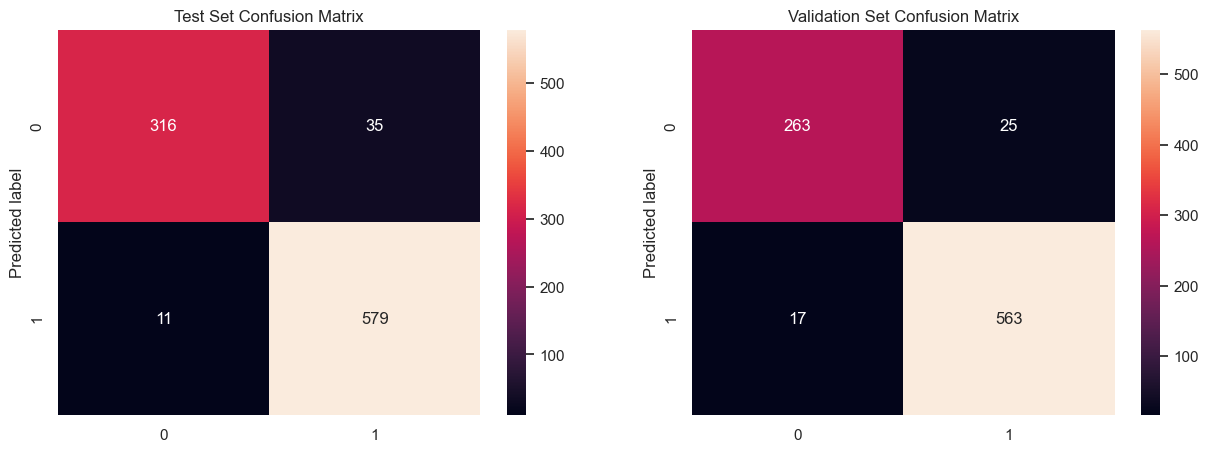

In [46]:
new_label_predictions = np.zeros(ic_test_predictions.shape)
thresholld = 0.5
for idx, row in enumerate(ic_test_predictions):
  new_label_predictions[idx] = 1 if row > thresholld else 0

ic_test_cm = confusion_matrix(ic_test_labels, new_label_predictions)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.heatmap(ic_test_cm, annot=True, fmt="d", ax=ax[0])
ax[0].set_title('Test Set Confusion Matrix')
ax[0].set_ylabel('Actual label')
ax[0].set_ylabel('Predicted label')

sns.heatmap(ic_cm_old, annot=True, fmt="d", ax=ax[1])
ax[1].set_title('Validation Set Confusion Matrix')
ax[1].set_ylabel('Actual label')
ax[1].set_ylabel('Predicted label')

plt.show()

The *precision* in the test set is $93.9$%.